In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# scale data
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

# set seed for reproducibility
tf.random.set_seed(42)

In [2]:
# utilities
def initIndex(df):
  df['DateTime'] = pd.to_datetime(df['Unnamed: 0'])
  df = df.set_index('DateTime')
  df.drop(columns="Unnamed: 0", inplace=True)
  return df

In [3]:
# RNN requires data to be in 3 dimensions
# (batch_size, time_steps, num_features)
# reshape the data into 3D array
def generate_data(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [4]:
# Load pre-processed datasets
m1_hourly_sales = initIndex(pd.read_csv('datasets/compute/m1_hourly_sales.csv'))
m2_hourly_sales = initIndex(pd.read_csv('datasets/compute/m2_hourly_sales.csv'))
m3_hourly_sales = initIndex(pd.read_csv('datasets/compute/m3_hourly_sales.csv'))

In [5]:
# train data sample
m1_hourly_sales[:-168].head()

,amount,weekday,is_weekend,is_holiday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
DateTime,,,,,,,,,,,
2023-10-01 00:00:00,11,6,1,0,0,0,0,0,0,0,1
2023-10-01 01:00:00,10,6,1,0,0,0,0,0,0,0,1
2023-10-01 02:00:00,4,6,1,0,0,0,0,0,0,0,1
2023-10-01 03:00:00,5,6,1,0,0,0,0,0,0,0,1
2023-10-01 04:00:00,4,6,1,0,0,0,0,0,0,0,1


In [6]:
m1_hourly_sales[:-168].tail()

,amount,weekday,is_weekend,is_holiday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
DateTime,,,,,,,,,,,
2023-10-24 19:00:00,14,1,0,1,0,1,0,0,0,0,0
2023-10-24 20:00:00,13,1,0,1,0,1,0,0,0,0,0
2023-10-24 21:00:00,14,1,0,1,0,1,0,0,0,0,0
2023-10-24 22:00:00,10,1,0,1,0,1,0,0,0,0,0
2023-10-24 23:00:00,10,1,0,1,0,1,0,0,0,0,0


In [7]:
# select last 7 day
m1_hourly_sales[-168:].head()

,amount,weekday,is_weekend,is_holiday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
DateTime,,,,,,,,,,,
2023-10-25 00:00:00,10,2,0,0,0,0,1,0,0,0,0
2023-10-25 01:00:00,10,2,0,0,0,0,1,0,0,0,0
2023-10-25 02:00:00,7,2,0,0,0,0,1,0,0,0,0
2023-10-25 03:00:00,12,2,0,0,0,0,1,0,0,0,0
2023-10-25 04:00:00,2,2,0,0,0,0,1,0,0,0,0


In [8]:
# split train and test
m1_train = m1_hourly_sales[:-168]
m1_test = m1_hourly_sales[-168:]

m2_train = m2_hourly_sales[:-168]
m2_test = m2_hourly_sales[-168:]

m3_train = m3_hourly_sales[:-168]
m3_test = m3_hourly_sales[-168:]

### Scaler

In [9]:
scaler = MinMaxScaler()
scaler.fit(m3_train[['amount']])
m3_scaled_train = scaler.transform(m3_train[['amount']])
m3_scaled_test = scaler.transform(m3_test[['amount']])

In [10]:
# define window size
window_size = 24

# generate data
X_train, y_train = generate_data(m3_scaled_train, window_size)
X_test, y_test = generate_data(m3_scaled_test, window_size)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(552, 24, 1)
(552, 1)
(144, 24, 1)
(144, 1)


### Research RNN Layer

In [11]:
# define LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(window_size, 1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.summary()

2023-12-21 17:28:13.287610: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-21 17:28:13.287635: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-21 17:28:13.287643: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-21 17:28:13.287690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-21 17:28:13.287724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 76929 (300.50 KB)
Trainable params: 76929 (300.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


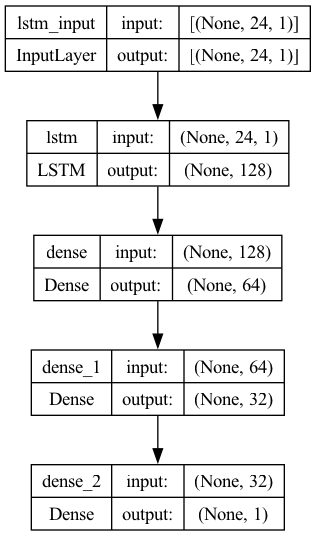

In [12]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
# fit model 
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=100,
          callbacks=[early_stop],
          verbose=1)

Epoch 1/100


2023-12-21 17:28:15.824305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 6s 99ms/step - loss: 0.0242 - val_loss: 0.0260
Epoch 2/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0219 - val_loss: 0.0246
Epoch 3/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0211 - val_loss: 0.0241
Epoch 4/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0210 - val_loss: 0.0233
Epoch 5/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0211 - val_loss: 0.0233
Epoch 6/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0206 - val_loss: 0.0230
Epoch 7/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0205 - val_loss: 0.0228
Epoch 8/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0206 - val_loss: 0.0222
Epoch 9/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0201 - val_loss: 0.0222
Epoch 10/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0196 - val_loss: 0.0228
Epoch 11/10

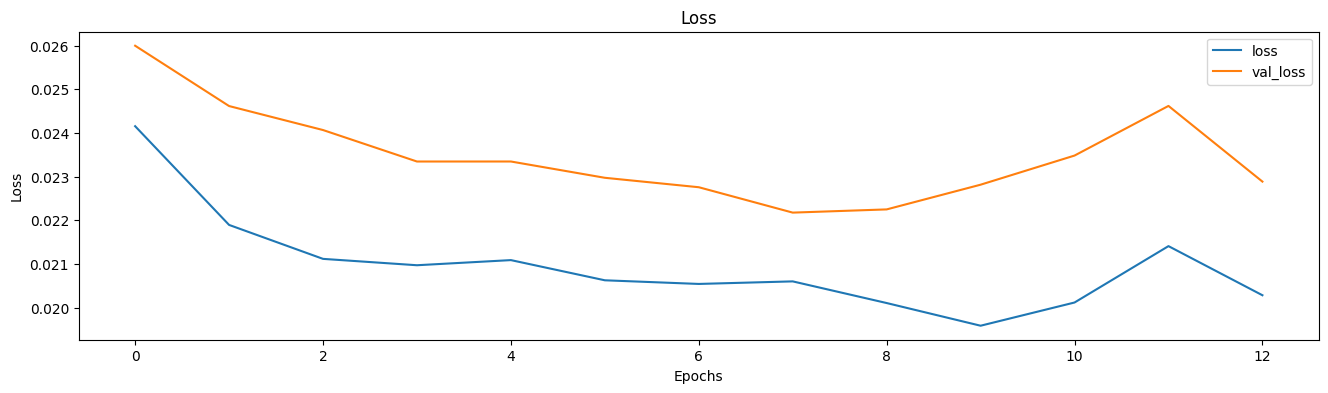

In [14]:
# plot loss
losses = pd.DataFrame(model.history.history)
losses.plot(figsize=(16, 4))
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');


5/5 [==============================] - 0s 8ms/step


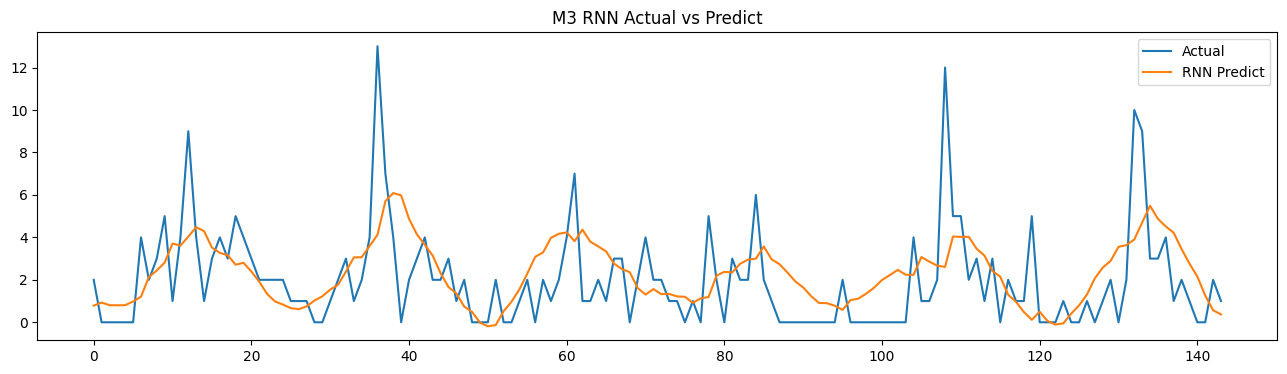

In [15]:
# plot actual vs predict
scaled_pred = model.predict(X_test)
pred = scaler.inverse_transform(scaled_pred)

plt.figure(figsize=(16, 4))
plt.plot(scaler.inverse_transform(y_test), label='Actual')
plt.plot(pred, label='RNN Predict')
plt.legend()
plt.title('M3 RNN Actual vs Predict');

### Grouping it to method and reuse

In [16]:
# grouping all process into method
def RNNevaluate(X_train, y_train, X_test, y_test, scaler, window_size):
  # fit model 
  model = Sequential()
  model.add(LSTM(128, input_shape=(window_size, 1)))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='mse')

  early_stop = EarlyStopping(monitor='val_loss', patience=3)

  model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

  # plot loss
  losses = pd.DataFrame(model.history.history)
  losses.plot(figsize=(16, 4))
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss');

  # predict
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)

  # inverse transform
  train_pred = scaler.inverse_transform(train_pred)
  test_pred = scaler.inverse_transform(test_pred)
  y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
  y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

  # evaluate
  train_mse = mean_squared_error(y_train, train_pred)
  test_mse = mean_squared_error(y_test, test_pred)
  print('Train MSE:', train_mse)
  print('Test  MSE:', test_mse)

  print('Train RMSE:', np.sqrt(train_mse))
  print('Test  RMSE:', np.sqrt(test_mse))

  # plot
  plt.figure(figsize=(16, 4))
  plt.plot(y_test, label='Actual')
  plt.plot(test_pred, label='RNN Predict')
  plt.legend()
  plt.title('RNN Actual vs Predict');

  return model

#### model declaration

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)               

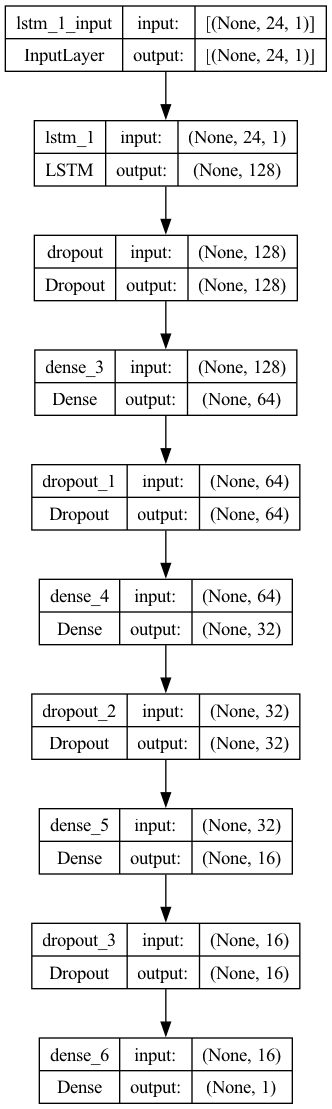

In [17]:
model = Sequential()
model.add(LSTM(128, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse')

model.summary()
plot_model(model, to_file='presentations/rnn-model.png', show_shapes=True, show_layer_names=True)

### run model

#### M1

Epoch 1/100
18/18 [==============================] - 2s 33ms/step - loss: 0.0527 - val_loss: 0.0416
Epoch 2/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0505 - val_loss: 0.0370
Epoch 3/100
18/18 [==============================] - 0s 19ms/step - loss: 0.0486 - val_loss: 0.0329
Epoch 4/100
18/18 [==============================] - 0s 23ms/step - loss: 0.0449 - val_loss: 0.0317
Epoch 5/100
18/18 [==============================] - 0s 18ms/step - loss: 0.0431 - val_loss: 0.0318
Epoch 6/100
18/18 [==============================] - 0s 21ms/step - loss: 0.0438 - val_loss: 0.0330
Epoch 7/100
5/5 [==============================] - 0s 7ms/step
Train MSE: 21.92159874864242
Test  MSE: 17.83430631047753
Train RMSE: 4.682050699067922
Test  RMSE: 4.22306835256991


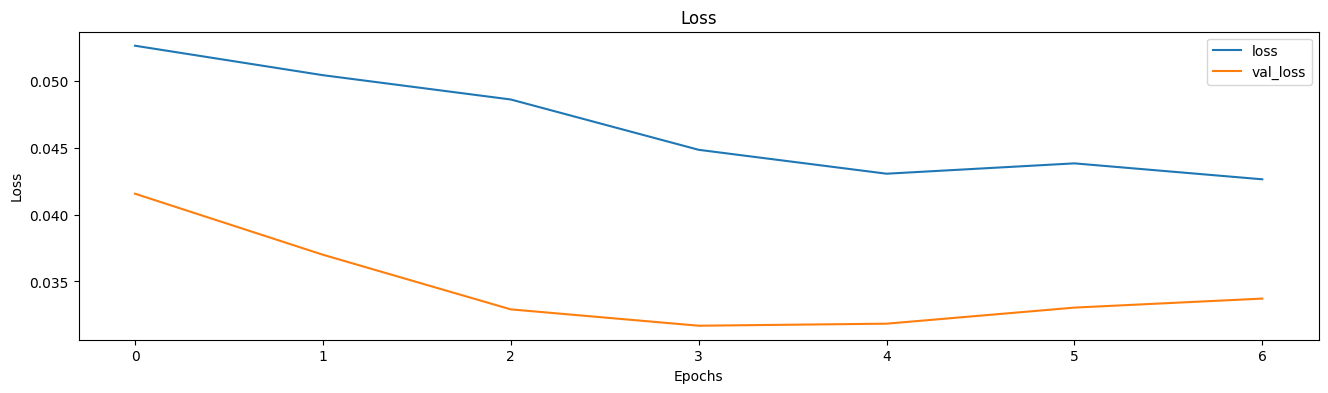

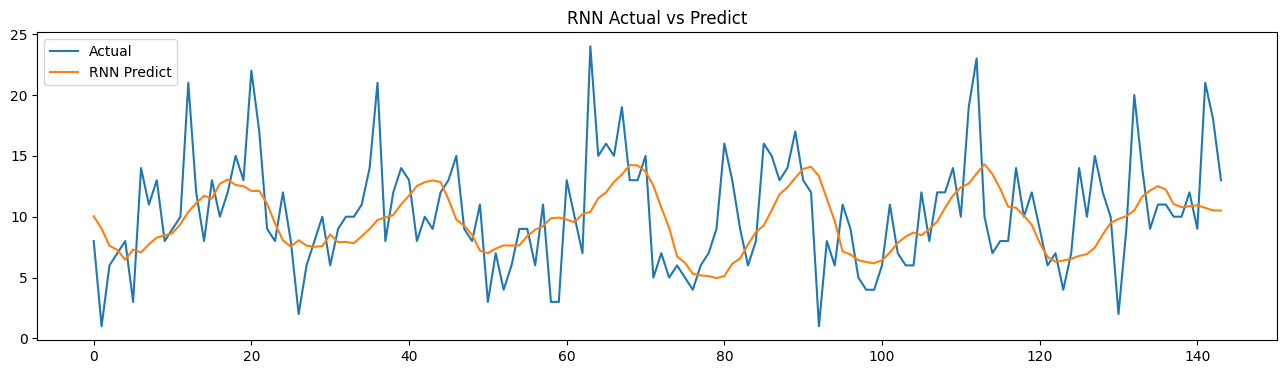

In [18]:
# M1 RNN evaluate
scaler = MinMaxScaler()
scaler.fit(m1_train[['amount']])
m1_scaled_train = scaler.transform(m1_train[['amount']])
m1_scaled_test = scaler.transform(m1_test[['amount']])

window_size = 24

# generate data
X_train, y_train = generate_data(m1_scaled_train, window_size)
X_test, y_test = generate_data(m1_scaled_test, window_size)

m1_model = RNNevaluate(X_train, y_train, X_test, y_test, scaler, window_size)

#### M2

Epoch 1/100
18/18 [==============================] - 3s 108ms/step - loss: 0.1241 - val_loss: 0.0963
Epoch 2/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0727 - val_loss: 0.0434
Epoch 3/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0580 - val_loss: 0.0374
Epoch 4/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0506 - val_loss: 0.0420
Epoch 5/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0526 - val_loss: 0.0368
Epoch 6/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0505 - val_loss: 0.0359
Epoch 7/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0479 - val_loss: 0.0357
Epoch 8/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0499 - val_loss: 0.0388
Epoch 9/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0436 - val_loss: 0.0339
Epoch 10/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0440 - val_loss: 0.040

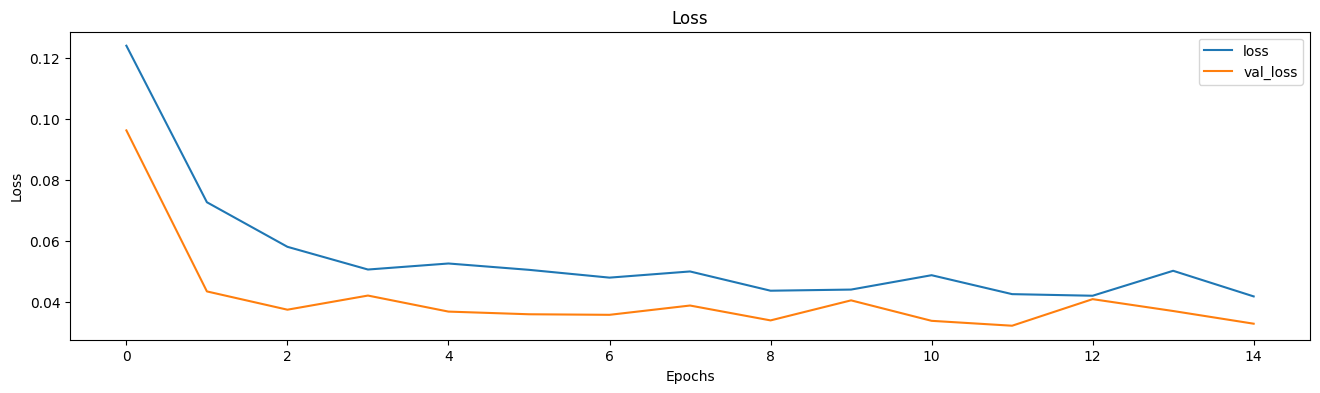

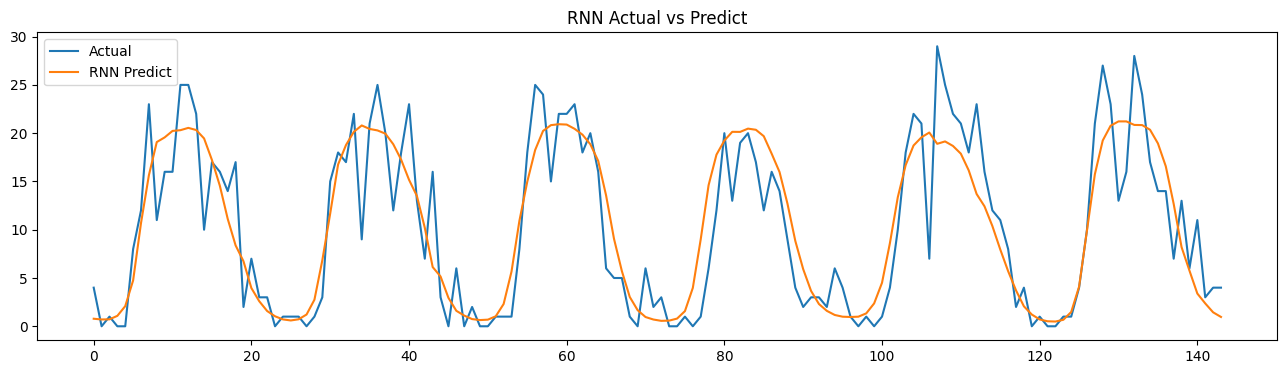

In [19]:
# M2 RNN evaluate
m2_scaler = MinMaxScaler()
m2_scaler.fit(m2_train[['amount']])
m2_scaled_train = scaler.transform(m2_train[['amount']])
m2_scaled_test = scaler.transform(m2_test[['amount']])

window_size = 24

# generate data
X_train, y_train = generate_data(m2_scaled_train, window_size)
X_test, y_test = generate_data(m2_scaled_test, window_size)

m2_model = RNNevaluate(X_train, y_train, X_test, y_test, scaler, window_size)

#### M3

Epoch 1/100
18/18 [==============================] - 1s 33ms/step - loss: 0.0869 - val_loss: 0.0470
Epoch 2/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0397 - val_loss: 0.0470
Epoch 3/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0383 - val_loss: 0.0388
Epoch 4/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0288 - val_loss: 0.0284
Epoch 5/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0248 - val_loss: 0.0302
Epoch 6/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0250 - val_loss: 0.0279
Epoch 7/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0246 - val_loss: 0.0285
Epoch 8/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0238 - val_loss: 0.0269
Epoch 9/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0236 - val_loss: 0.0268
Epoch 10/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0231 - val_loss: 0.0277

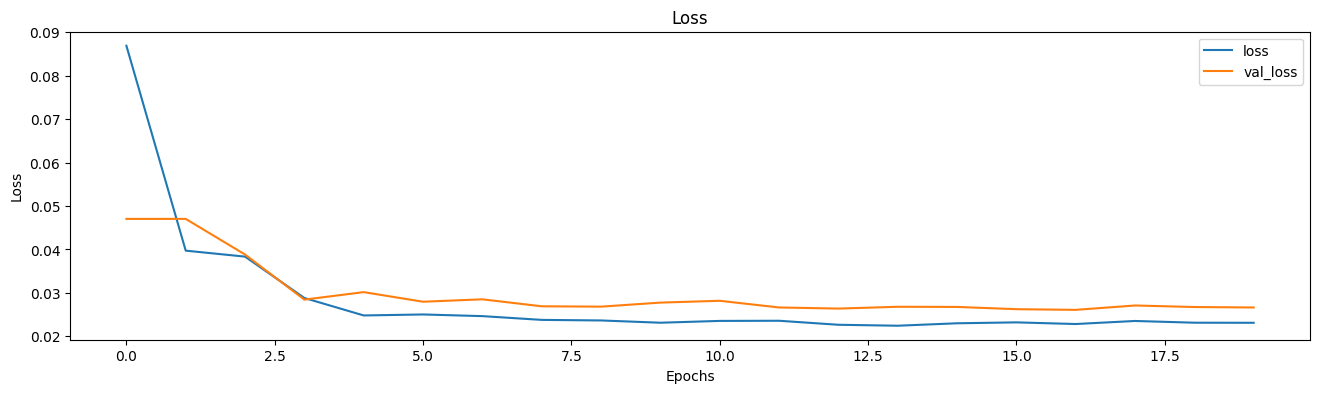

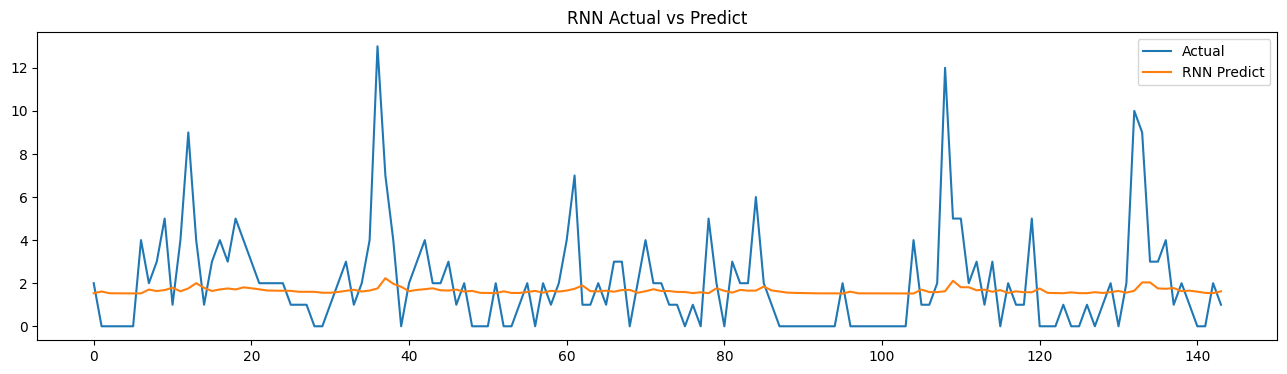

In [20]:
# M3 RNN evaluate
scaler = MinMaxScaler()
scaler.fit(m3_train[['amount']])
m3_scaled_train = scaler.transform(m3_train[['amount']])
m3_scaled_test = scaler.transform(m3_test[['amount']])

window_size = 24

# generate data
X_train, y_train = generate_data(m3_scaled_train, window_size)
X_test, y_test = generate_data(m3_scaled_test, window_size)

m3_model = RNNevaluate(X_train, y_train, X_test, y_test, scaler, window_size)

#### Model Usage 

In [21]:
def predict_next_n_hours(model, scaler, X_latest, n):
  window_size = 24
  prediction = []

  for i in range(n):
    next_value = model.predict(X_latest.reshape(1, window_size, 1))
    inversed_value = scaler.inverse_transform(next_value)
    prediction.append(inversed_value[0][0])
    X_latest = np.append(X_latest[1:], next_value[0][0])

  return prediction

In [22]:
# loop through predict to sum up transactions and check with transaction threshold
def should_refill_in(prediction, threshold=360):
  total = 0
  threshold = threshold
  for i in range(len(prediction)):
    total += prediction[i]
    if total >= threshold:
      print(f'Predicted transaction will reach {threshold} cups at next {i+1} hours')
      return i

In [23]:
# When should M2 refill
n = 24 * 2
company_cups_threshold = 360

next_pred = predict_next_n_hours(m2_model, m2_scaler, m2_scaled_test[-window_size:], n)
refill_index = should_refill_in(next_pred, company_cups_threshold)


1/1 [==============================] - 0s 12ms/step
Predicted transaction will reach 360 cups at next 31 hours


In [24]:
# cumulative transactions for next n hours
transactions_sum = 0
cumulative_transactions = np.zeros(n)
for i in range(len(next_pred)):
  transactions_sum += next_pred[i]
  cumulative_transactions[i] = transactions_sum


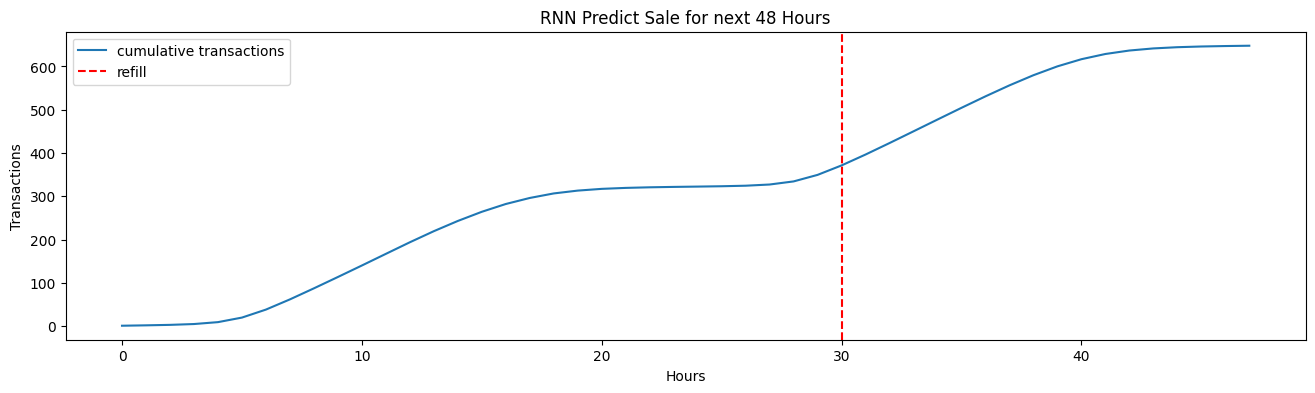

In [25]:
# plot cumulative transactions for next n hours
plt.figure(figsize=(16, 4))
# plt.plot(next_pred, label=f'next {n} hours')
plt.plot(cumulative_transactions, label='cumulative transactions')
plt.axvline(x=refill_index, color='red', linestyle='--', label='refill')
plt.legend()
plt.xlabel('Hours')
plt.ylabel('Transactions')
plt.title(f'RNN Predict Sale for next {n} Hours');

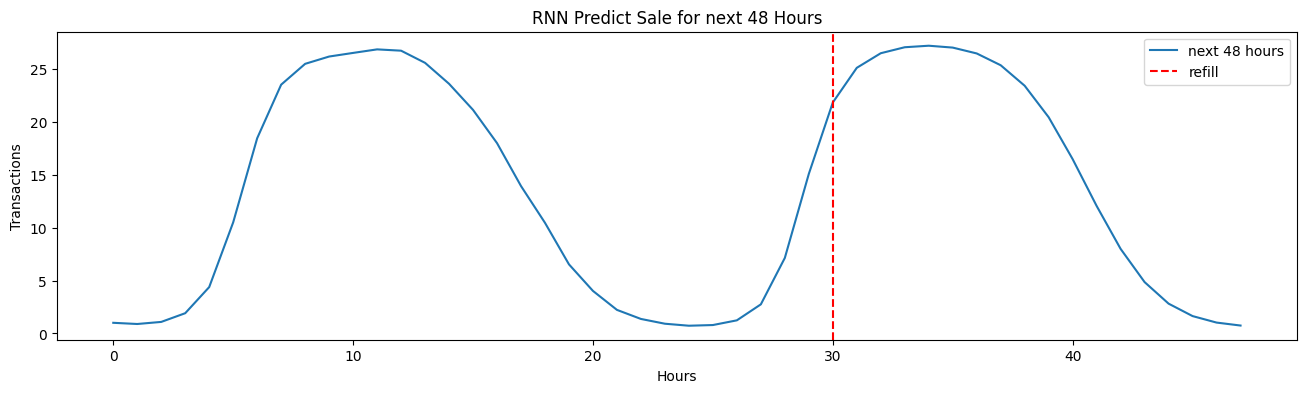

In [26]:
# plot cumulative transactions for next n hours
plt.figure(figsize=(16, 4))
plt.plot(next_pred, label=f'next {n} hours')
# plt.plot(cumulative_transactions, label='cumulative transactions')
plt.axvline(x=refill_index, color='red', linestyle='--', label='refill')
plt.legend()
plt.xlabel('Hours')
plt.ylabel('Transactions')
plt.title(f'RNN Predict Sale for next {n} Hours');

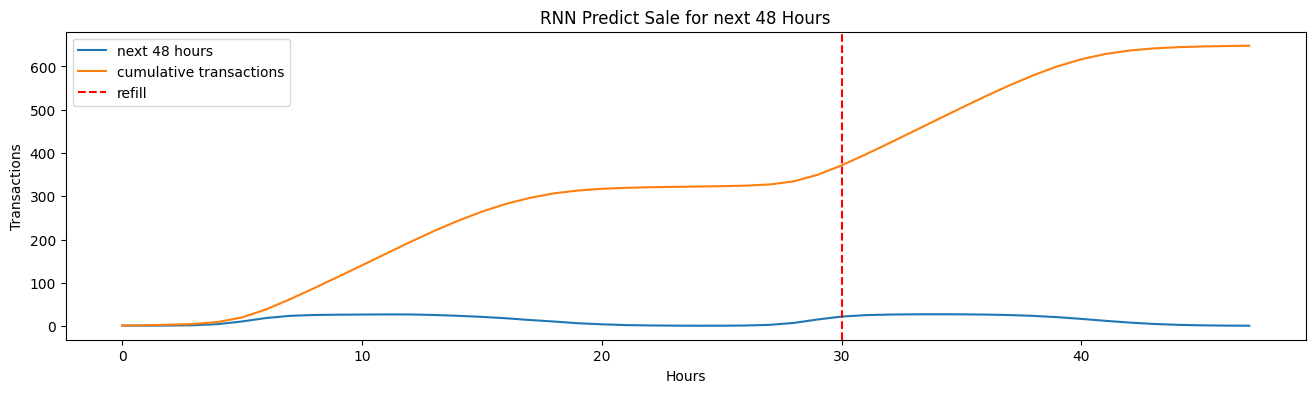

In [27]:
# plot cumulative transactions for next n hours
plt.figure(figsize=(16, 4))
plt.plot(next_pred, label=f'next {n} hours')
plt.plot(cumulative_transactions, label='cumulative transactions')
plt.axvline(x=refill_index, color='red', linestyle='--', label='refill')
plt.legend()
plt.xlabel('Hours')
plt.ylabel('Transactions')
plt.title(f'RNN Predict Sale for next {n} Hours');

### Oops I forgot to add features into RNN

#### Prepare function and parameters

In [28]:
target = ['amount']
features = ['is_weekend', 'is_holiday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [29]:
# utility method to scale data
def scaleWithMinMaxScaler(df, target, features):
  target_scaler = MinMaxScaler().fit(df[target])
  df_scaled = pd.DataFrame(target_scaler.transform(df[target]), columns=target, index=df.index)

  features_scaler = MinMaxScaler().fit(df[features])
  df_scaled[features] = features_scaler.transform(df[features])
  return df_scaled, target_scaler

In [30]:
# utility method to generate data
def generate_multi_features_data(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i])
        y.append(data['amount'].iloc[i])
    return np.array(X), np.array(y)

In [31]:
# methods to evaluate model
def multiRNNevaluate(model, X_train, y_train, X_test, y_test, scaler):
  # fit model
  model.compile(optimizer='adam', loss='mse')

  early_stop = EarlyStopping(monitor='val_loss', patience=3)

  model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

  # plot loss
  losses = pd.DataFrame(model.history.history)
  losses.plot(figsize=(16, 4))
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss');

  # predict
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)

  # inverse transform
  train_pred = scaler.inverse_transform(train_pred)
  test_pred = scaler.inverse_transform(test_pred)
  y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
  y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

  # evaluate
  train_mse = mean_squared_error(y_train, train_pred)
  test_mse = mean_squared_error(y_test, test_pred)
  print('Train MSE:', train_mse)
  print('Test  MSE:', test_mse)

  print('Train RMSE:', np.sqrt(train_mse))
  print('Test  RMSE:', np.sqrt(test_mse))

  # plot
  plt.figure(figsize=(16, 4))
  plt.plot(y_test, label='Actual')
  plt.plot(test_pred, label='RNN Predict')
  plt.legend()
  plt.title('RNN Actual vs Predict');

  return model

#### RNN model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 24, 48)            11328     
                                                                 
 dropout_10 (Dropout)        (None, 24, 48)            0         
                                                                 
 lstm_6 (LSTM)               (None, 24, 48)            18624     
                                                                 
 dropout_11 (Dropout)        (None, 24, 48)            0         
                                                                 
 lstm_7 (LSTM)               (None, 24, 48)            18624     
                                                                 
 dropout_12 (Dropout)        (None, 24, 48)            0         
                                                                 
 lstm_8 (LSTM)               (None, 48)               

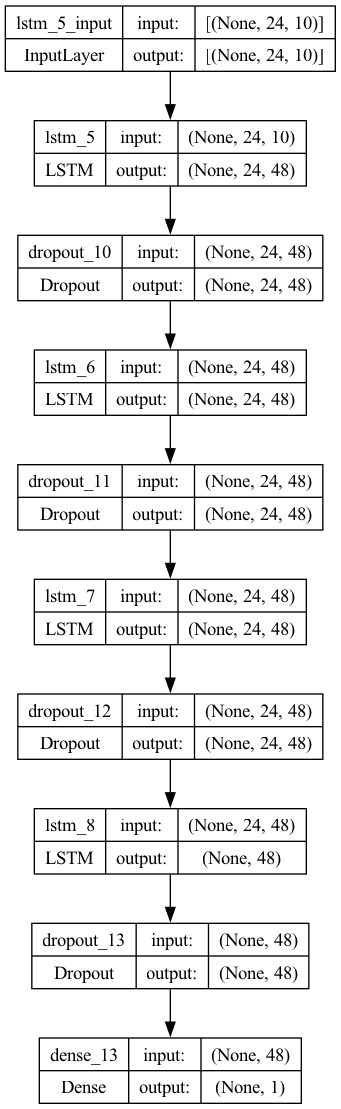

In [32]:
# multi features model
multiRNNmodel = Sequential()
multiRNNmodel.add(LSTM(48, return_sequences=True, input_shape=(24, 10)))
multiRNNmodel.add(Dropout(0.2))
multiRNNmodel.add(LSTM(units=48, return_sequences=True))
multiRNNmodel.add(Dropout(0.2))
multiRNNmodel.add(LSTM(units=48, return_sequences=True))
multiRNNmodel.add(Dropout(0.2))
multiRNNmodel.add(LSTM(units=48))
multiRNNmodel.add(Dropout(0.2))
multiRNNmodel.add(Dense(1))

multiRNNmodel.summary()
plot_model(multiRNNmodel, to_file='presentations/multi-rnn-model.png', show_shapes=True, show_layer_names=True)


#### M1

Epoch 1/100
18/18 [==============================] - 6s 142ms/step - loss: 0.0811 - val_loss: 0.0573
Epoch 2/100
18/18 [==============================] - 1s 33ms/step - loss: 0.0515 - val_loss: 0.0377
Epoch 3/100
18/18 [==============================] - 1s 30ms/step - loss: 0.0512 - val_loss: 0.0368
Epoch 4/100
18/18 [==============================] - 1s 34ms/step - loss: 0.0501 - val_loss: 0.0363
Epoch 5/100
18/18 [==============================] - 1s 32ms/step - loss: 0.0487 - val_loss: 0.0371
Epoch 6/100
18/18 [==============================] - 1s 31ms/step - loss: 0.0482 - val_loss: 0.0438
Epoch 7/100
5/5 [==============================] - 0s 32ms/step
Train MSE: 28.882419842439944
Test  MSE: 25.573701992065203
Train RMSE: 5.374236675327944
Test  RMSE: 5.057044788417955


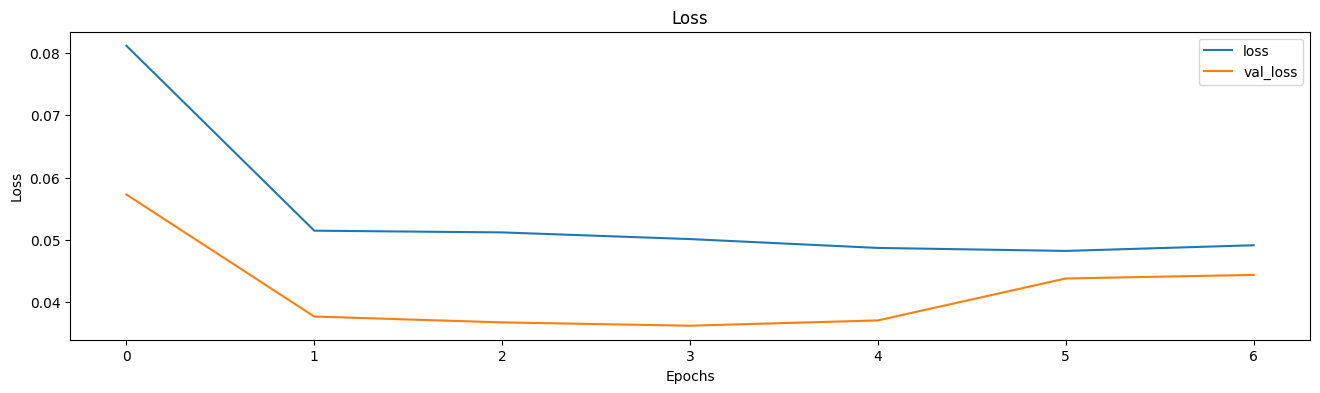

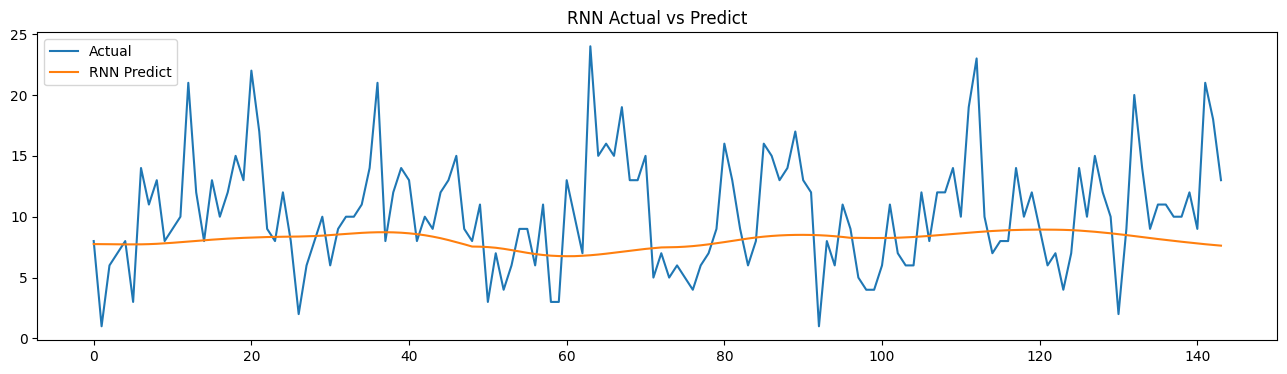

In [33]:
# scale the data
m1_scaled, target_scaler = scaleWithMinMaxScaler(m1_hourly_sales, target, features)

# split test train
m1_train_scaled = m1_scaled[:-168]
m1_test_scaled = m1_scaled[-168:]

# generate data
X_train, y_train = generate_multi_features_data(m1_train_scaled, window_size)
X_test, y_test = generate_multi_features_data(m1_test_scaled, window_size)

m1_multi_model = multiRNNevaluate(multiRNNmodel, X_train, y_train, X_test, y_test, target_scaler)

#### M2

Epoch 1/100
18/18 [==============================] - 6s 136ms/step - loss: 0.0412 - val_loss: 0.0234
Epoch 2/100
18/18 [==============================] - 1s 38ms/step - loss: 0.0262 - val_loss: 0.0245
Epoch 3/100
18/18 [==============================] - 1s 31ms/step - loss: 0.0260 - val_loss: 0.0254
Epoch 4/100
5/5 [==============================] - 0s 25ms/step
Train MSE: 20.361715667878446
Test  MSE: 22.209970481529567
Train RMSE: 4.5123957791708
Test  RMSE: 4.712745535410284


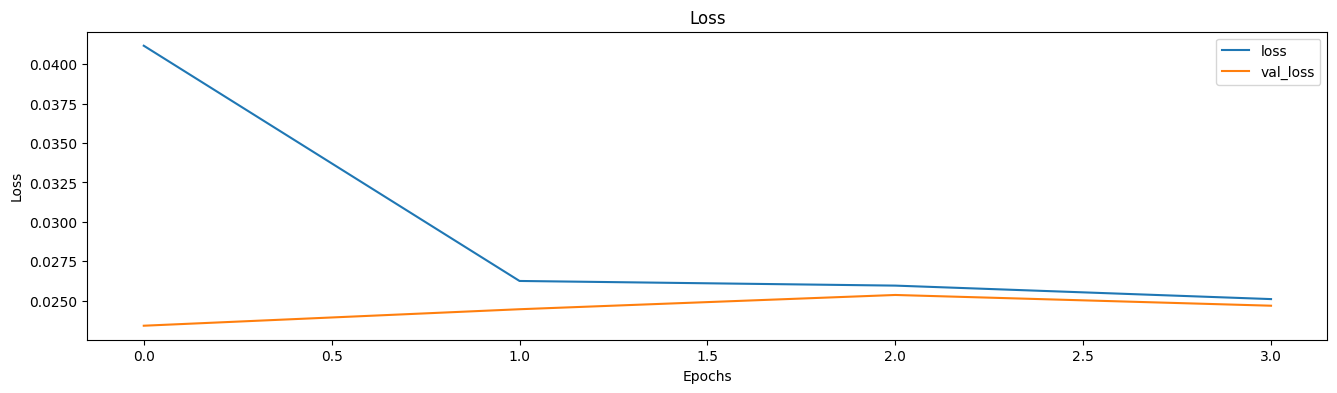

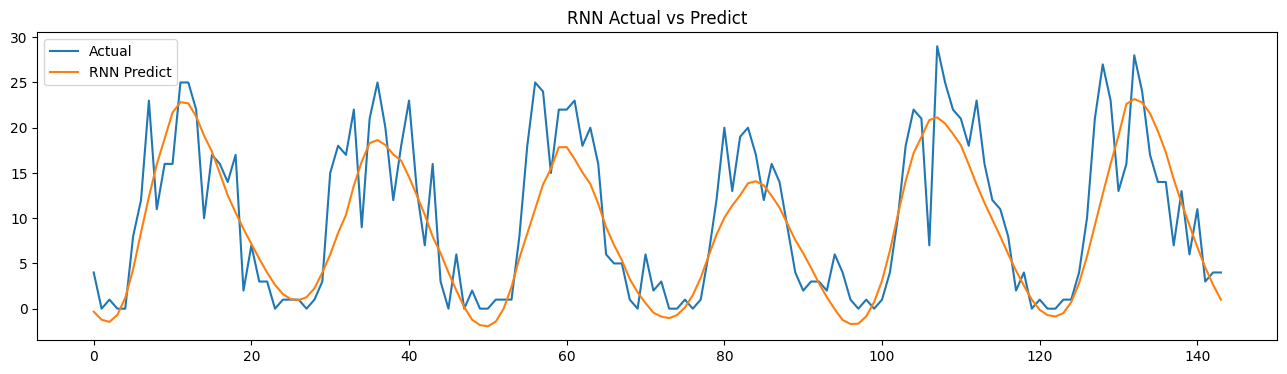

In [40]:
# scale the data
m2_scaled, target_scaler = scaleWithMinMaxScaler(m2_hourly_sales, target, features)

# split test train (24 * 7 = 168)
m2_train_scaled = m2_scaled[:-168]
m2_test_scaled = m2_scaled[-168:]

# generate data
X_train, y_train = generate_multi_features_data(m2_train_scaled, window_size)
X_test, y_test = generate_multi_features_data(m2_test_scaled, window_size)

m2_multi_model = multiRNNevaluate(multiRNNmodel, X_train, y_train, X_test, y_test, target_scaler)

#### M3


Epoch 1/100
18/18 [==============================] - 5s 121ms/step - loss: 0.0276 - val_loss: 0.0235
Epoch 2/100
18/18 [==============================] - 1s 35ms/step - loss: 0.0211 - val_loss: 0.0228
Epoch 3/100
18/18 [==============================] - 1s 32ms/step - loss: 0.0192 - val_loss: 0.0209
Epoch 4/100
18/18 [==============================] - 1s 31ms/step - loss: 0.0195 - val_loss: 0.0221
Epoch 5/100
18/18 [==============================] - 1s 32ms/step - loss: 0.0194 - val_loss: 0.0205
Epoch 6/100
18/18 [==============================] - 1s 31ms/step - loss: 0.0200 - val_loss: 0.0219
Epoch 7/100
18/18 [==============================] - 1s 32ms/step - loss: 0.0194 - val_loss: 0.0211
Epoch 8/100
18/18 [==============================] - 1s 37ms/step - loss: 0.0193 - val_loss: 0.0204
Epoch 9/100
18/18 [==============================] - 1s 34ms/step - loss: 0.0186 - val_loss: 0.0208
Epoch 10/100
18/18 [==============================] - 1s 30ms/step - loss: 0.0188 - val_loss: 0.021

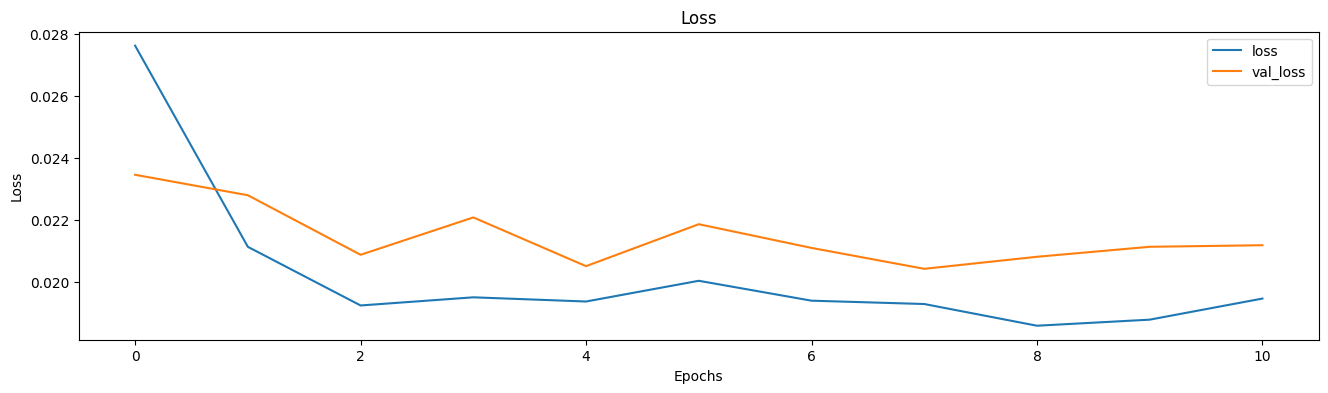

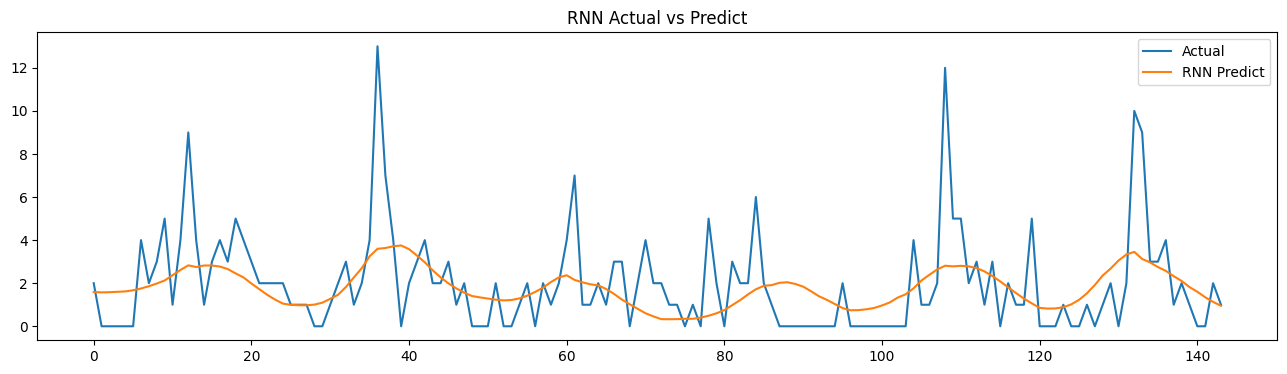

In [35]:
# scale the data
m3_scaled, target_scaler = scaleWithMinMaxScaler(m3_hourly_sales, target, features)

# split test train
m3_train_scaled = m3_scaled[:-168]
m3_test_scaled = m3_scaled[-168:]

# generate data
X_train, y_train = generate_multi_features_data(m3_train_scaled, window_size)
X_test, y_test = generate_multi_features_data(m3_test_scaled, window_size)

m3_multi_model = multiRNNevaluate(multiRNNmodel, X_train, y_train, X_test, y_test, target_scaler)

#### Usage

In [36]:
# When should M2 refill
n = 24 * 2
company_cups_threshold = 360

next_pred = predict_next_n_hours(m2_model, m2_scaler, m2_scaled_test[-window_size:], n)
refill_index = should_refill_in(next_pred, company_cups_threshold)

1/1 [==============================] - 0s 12ms/step
Predicted transaction will reach 360 cups at next 31 hours


In [37]:
# cumulative transactions for next n hours
transactions_sum = 0
cumulative_transactions = np.zeros(n)
for i in range(len(next_pred)):
  transactions_sum += next_pred[i]
  cumulative_transactions[i] = transactions_sum


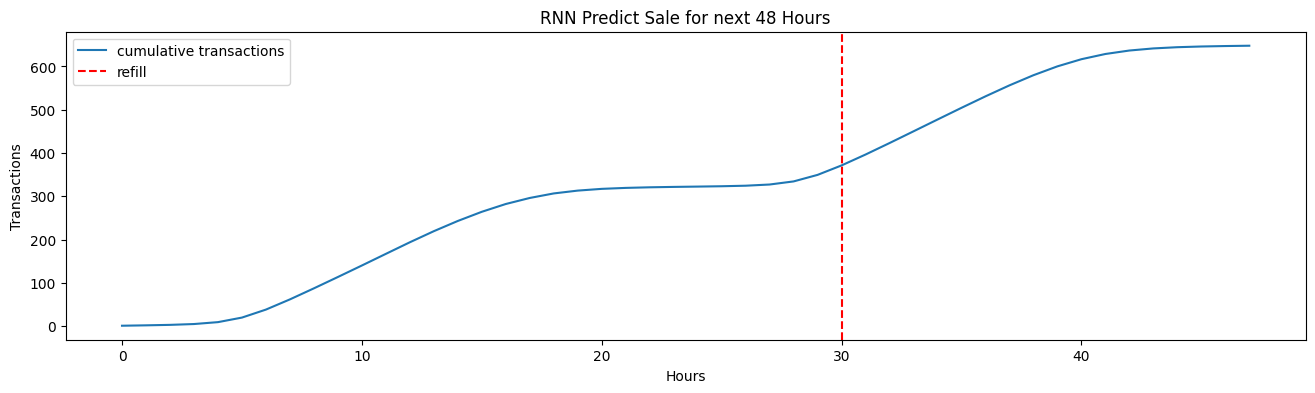

In [38]:
# plot cumulative transactions for next n hours
plt.figure(figsize=(16, 4))
# plt.plot(next_pred, label=f'next {n} hours')
plt.plot(cumulative_transactions, label='cumulative transactions')
plt.axvline(x=refill_index, color='red', linestyle='--', label='refill')
plt.legend()
plt.xlabel('Hours')
plt.ylabel('Transactions')
plt.title(f'RNN Predict Sale for next {n} Hours');

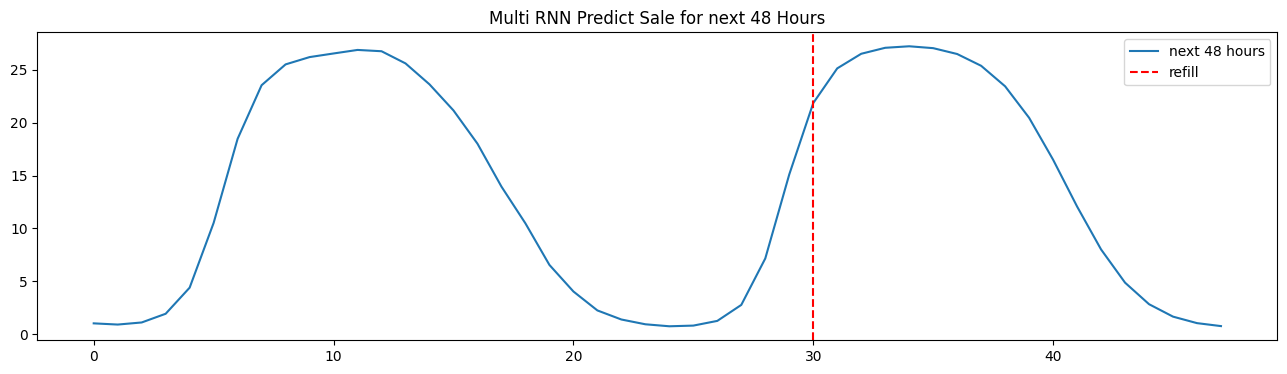

In [39]:
# plot
plt.figure(figsize=(16, 4))
plt.plot(next_pred, label=f'next {n} hours')
plt.axvline(x=refill_index, color='red', linestyle='--', label='refill')
plt.legend()
plt.title(f'Multi RNN Predict Sale for next {n} Hours');